In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm.notebook import tqdm

## download prepare and inspect data

In [2]:
import torch
from torch.utils.data import DataLoader

from datasets import load_dataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import LabelEncoder

# data = load_dataset('google/speech_commands', 'v0.01', split=['train','test'], trust_remote_code=True)
train_set = load_dataset('google/speech_commands', 'v0.01', split='train', trust_remote_code=True)
test_set = load_dataset('google/speech_commands', 'v0.01', split='test', trust_remote_code=True)

In [3]:
# inspect the raw dataset
print(type(train_set))
print("tain_set:\n", train_set)
print("test_set:\n", test_set)
print("labels: " ,np.sort(train_set.unique("label")))

<class 'datasets.arrow_dataset.Dataset'>
tain_set:
 Dataset({
    features: ['file', 'audio', 'label', 'is_unknown', 'speaker_id', 'utterance_id'],
    num_rows: 51093
})
test_set:
 Dataset({
    features: ['file', 'audio', 'label', 'is_unknown', 'speaker_id', 'utterance_id'],
    num_rows: 3081
})
labels:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]


In [4]:
train_set = train_set.filter(lambda x: x['label'] in np.sort(train_set.unique("label"))[:3])
test_set = test_set.filter(lambda x: x['label'] in np.sort(train_set.unique("label"))[:3])
print("tain_set:\n", train_set)
print("test_set:\n", test_set)

tain_set:
 Dataset({
    features: ['file', 'audio', 'label', 'is_unknown', 'speaker_id', 'utterance_id'],
    num_rows: 5556
})
test_set:
 Dataset({
    features: ['file', 'audio', 'label', 'is_unknown', 'speaker_id', 'utterance_id'],
    num_rows: 780
})


In [5]:
# train_set_audio = [train_set["audio"][i]["array"] for i in range(len(train_set))]
# test_set_audio = [test_set["audio"][i]["array"] for i in range(len(test_set))]
# num_train_samples = len(train_set)
# num_test_samples = len(test_set)
# print("num_train_samples: ", num_train_samples)
# print("num_test_samples: ", num_test_samples)

# # inspect the audio data
# train_set_audio_lengths = np.array([len(train_set_audio[i]) for i in range(len(train_set_audio))])
# test_set_audio_lengths = np.array([len(test_set_audio[i]) for i in range(len(test_set_audio))])
# train_set_audio_std = np.std(train_set_audio_lengths)
# test_set_audio_std = np.std(test_set_audio_lengths)
# train_set_audio_mean = np.mean(train_set_audio_lengths)
# test_set_audio_mean = np.mean(test_set_audio_lengths)
# print("train_set_audio mean: ", train_set_audio_mean)
# print("train_set_audio std: ", train_set_audio_std)
# print("test_set_audio mean: ", test_set_audio_mean)
# print("test_set_audio std: ", test_set_audio_std)

# # filter out audio arrays that are over 3 standard deviations from the mean
# # get the indecies
# train_set_audio_filtered_indecies = np.where(train_set_audio_lengths < train_set_audio_mean + 3 * train_set_audio_std and
#                                              train_set_audio_lengths > train_set_audio_mean - 3 * train_set_audio_std)
# train_set = [train_set[i] for i in train_set_audio_filtered_indecies]
# test_set_audio_filtered_indecies = np.where(test_set_audio_lengths < test_set_audio_mean + 3 * test_set_audio_std and
#                                             test_set_audio_lengths > test_set_audio_mean - 3 * test_set_audio_std)
# test_set = [test_set[i] for i in test_set_audio_filtered_indecies]
# print("num_train_samples_filtered: ", len(train_set))
# print("num_test_samples_filtered: ", len(test_set))

# # get a count of all audio arrays that are more than 16000 long
# count_large = 0
# count_small = 0
# for i in range(len(train_set_audio)):
#     len_sample = len(train_set_audio[i]["array"])
#     if len_sample > 16000:
#         count_large += 1
#     if len_sample < 16000:
#         count_small += 1

# print("count_larger: ", count_large)
# print("count_smaller: ", count_small)
# print("percent divergent: ", (count_large + count_small) / num_train_samples)

# # free up memory
# del train_set_audio, test_set_audio

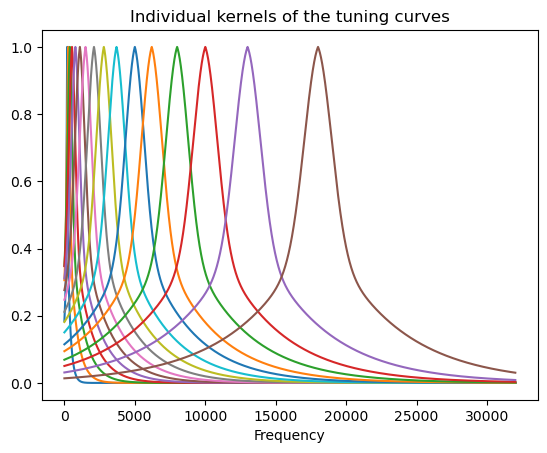

In [6]:
from utils import create_individual_kernel
sr = 16000
wave_length = 16000

# create tuning curves kernels
params = [
    (200, 40, 200),
    (520, 104, 280),
    (840, 168, 390),
    (1160, 232, 540),
    (1480, 296, 780),
    (1800, 360, 1100),
    (2120, 424, 1500),
    (2440, 488, 2100),
    (2760, 552, 2800),
    (3080, 616, 3700),
    (3400, 680, 5000),
    (3720, 744, 6200),
    (4040, 808, 8000),
    (4360, 872, 10000),
    (4680, 936, 13000),
    (5000, 1000, 18000)
]
kernels = [create_individual_kernel(wave_length*2 ,*p) for p in params]
for k in kernels:
    plt.plot(k)
plt.title("Individual kernels of the tuning curves")
plt.xlabel("Frequency")
plt.show()

In [7]:
from spike_encoding import convert_audio_to_spectrogram, apply_TCs_kernels, encode_spec_to_spikes_IF
from spike_encoding import encode_to_spikes_IF, encode_to_spikes_TCs, encode_to_spikes_rbf, encode_to_spikes_melspec
# prepare the data loader
max_length = 16000  # or your desired length
all_labels = train_set['label']
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(all_labels)
print("all_labels:", np.unique(all_labels))
print("encoded_labels:", np.unique(encoded_labels))

def collate_fn(batch):
    max_length = 16000
    # waveforms, labels = zip(*[(item[0].squeeze()[:max_length], item[2]) for item in batch])
    waveforms, labels = zip(*[(torch.tensor(item['audio']['array'][:max_length]) , item['label'])
                              for item in batch])
    # Ensure each waveform is 1D before padding
    waveforms = [waveform if waveform.ndim == 1 else waveform.mean(dim=0) for waveform in waveforms]

    #print("Shapes before padding:", [w.shape for w in waveforms])  # Add this line

    waveforms_padded = pad_sequence(waveforms, batch_first=True, padding_value=0)

    labels = label_encoder.transform(labels)  # Encode the labels as integers

    labels = torch.tensor(labels)
    return waveforms_padded, labels

def collate_fn_encoded(batch):
    waveforms_padded, labels = collate_fn(batch)
    specs, freqs = convert_audio_to_spectrogram(waveforms_padded, sr, spec_method="mel")
    specs = apply_TCs_kernels(specs, freqs, kernels)
    # normalize specs along the batch dimension
    specs = (specs - specs.mean(axis=0)) / specs.std(axis=0)
    # normalize to [0,1]
    specs = (specs - specs.min()) / (specs.max() - specs.min())
    
    spikes = encode_spec_to_spikes_IF(specs, V_th=0.05)
    
    x = specs
    x = torch.tensor(x, dtype=torch.float32)
    return x, labels

train_loader_raw = DataLoader(train_set, batch_size=64, shuffle=True, collate_fn=collate_fn, drop_last=True)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, collate_fn=collate_fn_encoded, drop_last=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, collate_fn=collate_fn_encoded, drop_last=True)

all_labels: [0 1 2]
encoded_labels: [0 1 2]


sample batch:
shape: torch.Size([64, 16, 64]) torch.Size([64])


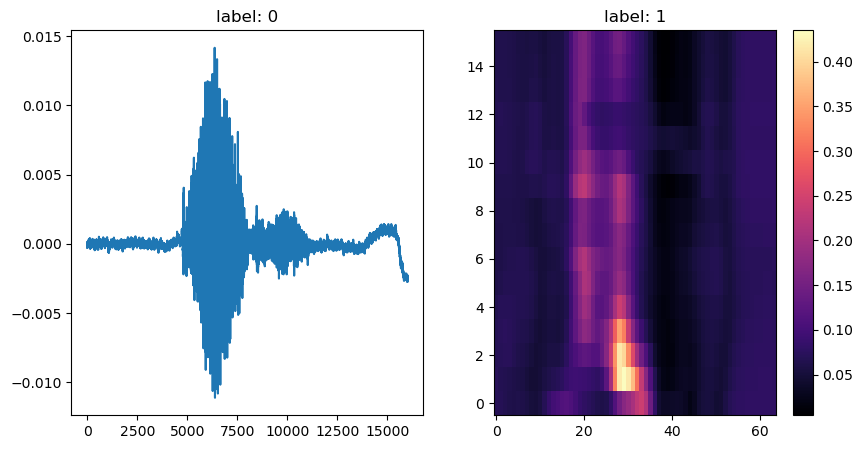

In [8]:
# raw data sample
sample_batch_raw = next(iter(train_loader_raw))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(sample_batch_raw[0][0].numpy())
plt.title(f"label: {sample_batch_raw[1][0].item()}")

# show samples
sample_batch = next(iter(train_loader))
# reinstialize the train_loader to get the first batch
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, collate_fn=collate_fn_encoded, drop_last=True)

# inspect one sample and its label
idx = 0
sample_inputs = sample_batch[0]
print("sample batch:")
print("shape:", sample_batch[0].shape, sample_batch[1].shape)

plt.subplot(1, 2, 2)
plt.imshow(sample_inputs[idx].numpy(), aspect='auto', origin='lower', cmap='magma')
plt.title(f"label: {sample_batch[1][idx].item()}")
plt.colorbar()
plt.show()
# # play the audio
# import IPython.display as ipd
# import scipy.io.wavfile
# ipd.Audio(sample_batch[0][0].numpy(), rate=16000)
# scipy.io.wavfile.write('sample.wav', 16000, sample_batch[0][0].numpy())

## tuning curves, encode raw audio to spikes 

(64, 16, 64)
(16, 64)


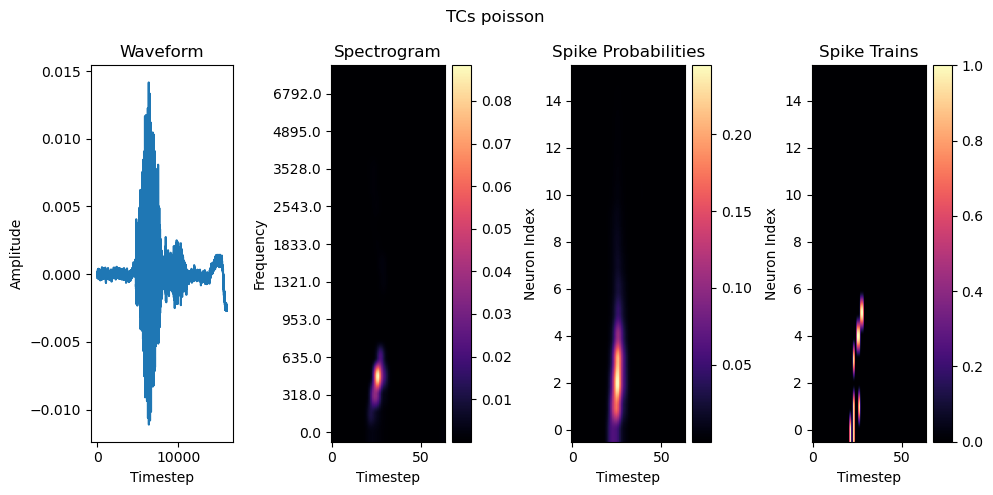

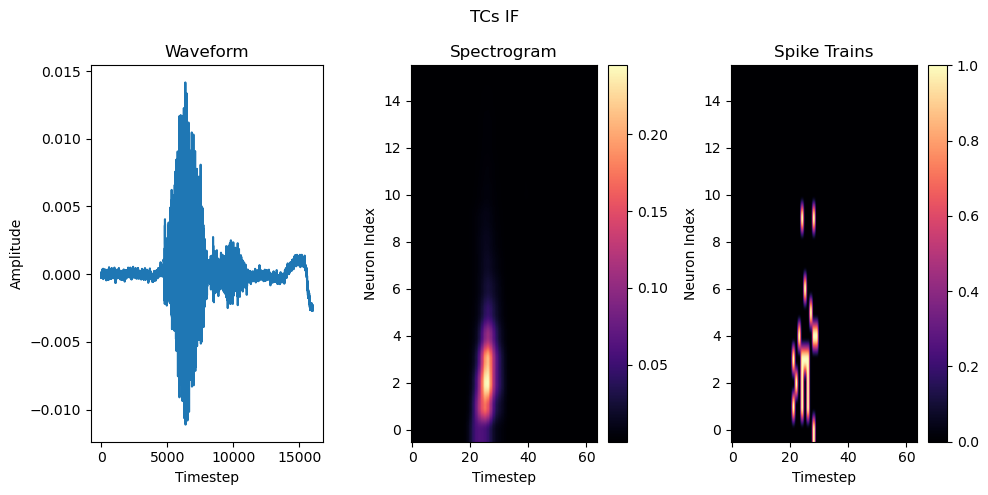

In [21]:
sample_inputs_raw = sample_batch_raw[0]
sample_spikes, spikes_probs, specs, spec_fr = encode_to_spikes_TCs(sample_inputs_raw,
                                                              kernels,
                                                              spec_method='mel',
                                                              spike_prob_scale=2)

print(sample_spikes.shape)
print(sample_spikes[0].shape)

plt.figure(figsize=(10, 5))
plt.suptitle('TCs poisson')

plt.subplot(1, 4, 1)
plt.plot(sample_inputs_raw[0].numpy())
plt.title('Waveform')
plt.xlabel('Timestep')
plt.ylabel('Amplitude')

plt.subplot(1, 4, 2)
plt.imshow(specs[0], aspect='auto', origin='lower', cmap='magma')
plt.title('Spectrogram')
plt.xlabel('Timestep')
plt.ylabel('Frequency')
plt.colorbar()
# put the frequency on the y-axis
# show only 10 spread out frequencies
plt.yticks(np.arange(0, len(spec_fr), len(spec_fr)//10), np.round(spec_fr[::len(spec_fr)//10], 0))

# spike probabilities
plt.subplot(1, 4, 3)
plt.imshow(spikes_probs[0], aspect='auto', origin='lower', cmap='magma')
plt.title('Spike Probabilities')
plt.xlabel('Timestep')
plt.ylabel('Neuron Index')
plt.colorbar()

plt.subplot(1, 4, 4)
plt.imshow(sample_spikes[0], aspect='auto', origin='lower', cmap='magma')
plt.title('Spike Trains')
plt.xlabel('Timestep')
plt.ylabel('Neuron Index')
plt.colorbar()

plt.tight_layout()
plt.show()

# # inspect the spike trains from rbfs
# sample_spikes = encode_to_spikes_rbf(sample_inputs, 16000)
# print(sample_spikes.shape)
# print(sample_spikes[0].shape)

# plt.figure(figsize=(10, 5))
# plt.suptitle('RBFs')

# plt.subplot(2, 2, 1)
# plt.plot(sample_inputs_raw[0].numpy())
# plt.title('Waveform')
# plt.xlabel('Timestep')
# plt.ylabel('Amplitude')

# plt.subplot(2, 2, 2)
# plt.imshow(sample_spikes[0], aspect='auto', origin='lower', cmap='magma')
# plt.title('Spike Trains')
# plt.xlabel('Timestep')
# plt.ylabel('Neuron Index')
# plt.colorbar()

# # inspect the spike trains from melspec
# sample_spikes = encode_to_spikes_melspec(sample_inputs, 16000)

# print(sample_spikes.shape)
# print(sample_spikes[0].shape)

# plt.subplot(2, 2, 3)
# plt.plot(sample_inputs_raw[0].numpy())
# plt.title('Waveform')
# plt.xlabel('Timestep')
# plt.ylabel('Amplitude')

# plt.subplot(2, 2, 4)
# plt.imshow(sample_spikes[0].numpy(), aspect='auto', origin='lower', cmap='magma')
# plt.title('Spike Trains')
# plt.xlabel('Timestep')
# plt.ylabel('Neuron Index')
# plt.colorbar()

# plt.tight_layout()
# plt.show()

spikes, specs, freqs = encode_to_spikes_IF(sample_inputs_raw, 16000, kernels, V_th=0.05)

plt.figure(figsize=(10, 5))
plt.suptitle('TCs IF')

plt.subplot(1, 3, 1)
plt.plot(sample_inputs_raw[0].numpy())
plt.title('Waveform')
plt.xlabel('Timestep')
plt.ylabel('Amplitude')

plt.subplot(1, 3, 2)
plt.imshow(specs[0], aspect='auto', origin='lower', cmap='magma')
plt.title('Spectrogram')
plt.xlabel('Timestep')
plt.ylabel('Neuron Index')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(spikes[0], aspect='auto', origin='lower', cmap='magma')
plt.title('Spike Trains')
plt.xlabel('Timestep')
plt.ylabel('Neuron Index')
plt.colorbar()

plt.tight_layout()
plt.show()

In [10]:
# create an array of surragate data 
surrogate_input = torch.tensor(np.random.rand(798, 64, 64, 1, 16), dtype=torch.float32)
surrogate_labels = torch.tensor(np.random.randint(0, 31, size=(798, 64)), dtype=torch.long)
surrogate_data = [(surrogate_input[i], surrogate_labels[i]) for i in range(789)]

In [11]:
from models import SJNetwork
from spikingjelly.activation_based import functional, surrogate, neuron
 
import os
import sys
from torch.utils.tensorboard import SummaryWriter
import time
import datetime
from torch.cuda.amp import GradScaler, autocast
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device: ", device)

out_dir = "logs/TCs_mel_3"
os.makedirs(out_dir, exist_ok=True)

input_size = sample_inputs.shape[1]
num_classes = len(np.unique(encoded_labels))

channels = 16
lr = 1e-2
epochs = 10

print("num classes: ", num_classes)
print("input size: ", input_size)

# create the network
model = SJNetwork(channels=channels,
                output_size=num_classes,
                spiking_neuron=neuron.LIFNode, surrogate_function=surrogate.ATan(), detach_reset=True)
functional.set_step_mode(model, 'm')

model.to(device)

scaler = None
start_epoch = 0
max_test_acc = -1
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

writer = SummaryWriter(out_dir, purge_step=start_epoch)

# print(model)
max_iter = np.inf
for epoch in tqdm(range(start_epoch, epochs), desc='epochs', leave=True):
    start_time = time.time()
    model.train()
    train_loss = 0
    train_acc = 0
    train_samples = 0
    
    iteration = 0
    for input, label in tqdm(train_loader, desc='train-iteration', leave=False):
    # for frame, label in tqdm(surrogate_data, desc='train-iteration', leave=False):
        if iteration > max_iter:
            break
        iteration += 1
        optimizer.zero_grad()
        if isinstance(input, np.ndarray):
            input = torch.tensor(input, dtype=torch.float32)
        # shape of frame(1d) is [Batch, X, Timesteps]
        # wanted shape is [Timesteps, Batch, channels, X]
        
        input = input.transpose(0, 2).transpose(1, 2)
        input = input.unsqueeze(2)
        input = input.to(device)
            
        label = label.to(device)
        label_onehot = F.one_hot(label, num_classes).float()

        if scaler is not None:
            out_fr = model(input).mean(0)

            loss = F.mse_loss(out_fr, label_onehot)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            out_fr = model(input).mean(0)

            loss = F.mse_loss(out_fr, label_onehot)
            loss.backward()
            optimizer.step()

        train_samples += label.numel()
        train_loss += loss.item() * label.numel()
        train_acc += (out_fr.argmax(1) == label).float().sum().item()

        functional.reset_net(model)

    train_time = time.time()
    train_speed = train_samples / (train_time - start_time)
    train_loss /= train_samples
    train_acc /= train_samples

    writer.add_scalar('train_loss', train_loss, epoch)
    writer.add_scalar('train_acc', train_acc, epoch)
    lr_scheduler.step()

    model.eval()
    test_loss = 0
    test_acc = 0
    test_samples = 0
    with torch.no_grad():
        iteration = 0
        for input, label in tqdm(test_loader, desc='test-iteration', leave=False):
            if iteration > max_iter:
                break
            iteration += 1
            if isinstance(input, np.ndarray):
                input = torch.tensor(input, dtype=torch.float32)
            # shape of frame(1d) is [Batch, X, Timesteps]
            # wanted shape is [Timesteps, Batch, channels, X]
            input = input.transpose(0, 2).transpose(1, 2)
            input = input.unsqueeze(2)
            input = input.to(device)
            label = label.to(device)
            label_onehot = F.one_hot(label, num_classes).float()
            out_fr = model(input).mean(0)
            loss = F.mse_loss(out_fr, label_onehot)
            test_samples += label.numel()
            test_loss += loss.item() * label.numel()
            test_acc += (out_fr.argmax(1) == label).float().sum().item()
            functional.reset_net(model)
    test_time = time.time()
    test_speed = test_samples / (test_time - train_time)
    test_loss /= test_samples
    test_acc /= test_samples
    writer.add_scalar('test_loss', test_loss, epoch)
    writer.add_scalar('test_acc', test_acc, epoch)

    save_max = False
    if test_acc > max_test_acc:
        max_test_acc = test_acc
        save_max = True

    checkpoint = {
        'net': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler.state_dict(),
        'epoch': epoch,
        'max_test_acc': max_test_acc
    }

    if save_max:
        torch.save(checkpoint, os.path.join(out_dir, 'checkpoint_max.pth'))

    torch.save(checkpoint, os.path.join(out_dir, 'checkpoint_latest.pth'))

    args = {
        'channels': channels,
        'lr': lr,
        'epochs': epochs,
        'out_dir': out_dir,
    }
    print(args)
    print(out_dir)
    print(f'epoch = {epoch}, train_loss ={train_loss: .4f}, train_acc ={train_acc: .4f}, test_loss ={test_loss: .4f}, test_acc ={test_acc: .4f}, max_test_acc ={max_test_acc: .4f}')
    print(f'train speed ={train_speed: .4f} images/s, test speed ={test_speed: .4f} images/s')
    print(f'escape time = {(datetime.datetime.now() + datetime.timedelta(seconds=(time.time() - start_time) * (args["epochs"] - epoch))).strftime("%Y-%m-%d %H:%M:%S")}\n')

device:  cpu
input size:  16
num classes:  3


epochs:   0%|          | 0/10 [00:00<?, ?it/s]

train-iteration:   0%|          | 0/86 [00:00<?, ?it/s]

#### non_zeros_count:  83


test-iteration:   0%|          | 0/12 [00:00<?, ?it/s]

{'channels': 16, 'lr': 0.01, 'epochs': 10, 'out_dir': 'logs/TCs_mel_3'}
logs/TCs_mel_3
epoch = 0, train_loss = 0.2406, train_acc = 0.4093, test_loss = 0.1980, test_acc = 0.6641, max_test_acc = 0.6641
train speed = 80.3141 images/s, test speed = 89.9507 images/s
escape time = 2024-09-12 00:38:06



train-iteration:   0%|          | 0/86 [00:00<?, ?it/s]

#### non_zeros_count:  86


test-iteration:   0%|          | 0/12 [00:00<?, ?it/s]

{'channels': 16, 'lr': 0.01, 'epochs': 10, 'out_dir': 'logs/TCs_mel_3'}
logs/TCs_mel_3
epoch = 1, train_loss = 0.1896, train_acc = 0.6063, test_loss = 0.1811, test_acc = 0.6042, max_test_acc = 0.6641
train speed = 86.8827 images/s, test speed = 102.1715 images/s
escape time = 2024-09-12 00:37:04



train-iteration:   0%|          | 0/86 [00:00<?, ?it/s]

#### non_zeros_count:  86


test-iteration:   0%|          | 0/12 [00:00<?, ?it/s]

{'channels': 16, 'lr': 0.01, 'epochs': 10, 'out_dir': 'logs/TCs_mel_3'}
logs/TCs_mel_3
epoch = 2, train_loss = 0.1774, train_acc = 0.6577, test_loss = 0.1653, test_acc = 0.6185, max_test_acc = 0.6641
train speed = 82.5174 images/s, test speed = 99.6474 images/s
escape time = 2024-09-12 00:37:36



train-iteration:   0%|          | 0/86 [00:00<?, ?it/s]

#### non_zeros_count:  86


test-iteration:   0%|          | 0/12 [00:00<?, ?it/s]

{'channels': 16, 'lr': 0.01, 'epochs': 10, 'out_dir': 'logs/TCs_mel_3'}
logs/TCs_mel_3
epoch = 3, train_loss = 0.1723, train_acc = 0.6801, test_loss = 0.1687, test_acc = 0.6263, max_test_acc = 0.6641
train speed = 87.6074 images/s, test speed = 98.6344 images/s
escape time = 2024-09-12 00:37:05



train-iteration:   0%|          | 0/86 [00:00<?, ?it/s]

#### non_zeros_count:  86


test-iteration:   0%|          | 0/12 [00:00<?, ?it/s]

{'channels': 16, 'lr': 0.01, 'epochs': 10, 'out_dir': 'logs/TCs_mel_3'}
logs/TCs_mel_3
epoch = 4, train_loss = 0.1694, train_acc = 0.6884, test_loss = 0.1609, test_acc = 0.6081, max_test_acc = 0.6641
train speed = 85.9958 images/s, test speed = 99.4870 images/s
escape time = 2024-09-12 00:37:13



train-iteration:   0%|          | 0/86 [00:00<?, ?it/s]

#### non_zeros_count:  86


test-iteration:   0%|          | 0/12 [00:00<?, ?it/s]

{'channels': 16, 'lr': 0.01, 'epochs': 10, 'out_dir': 'logs/TCs_mel_3'}
logs/TCs_mel_3
epoch = 5, train_loss = 0.1684, train_acc = 0.6930, test_loss = 0.1615, test_acc = 0.6354, max_test_acc = 0.6641
train speed = 83.7188 images/s, test speed = 99.0125 images/s
escape time = 2024-09-12 00:37:24



train-iteration:   0%|          | 0/86 [00:00<?, ?it/s]

#### non_zeros_count:  86


test-iteration:   0%|          | 0/12 [00:00<?, ?it/s]

{'channels': 16, 'lr': 0.01, 'epochs': 10, 'out_dir': 'logs/TCs_mel_3'}
logs/TCs_mel_3
epoch = 6, train_loss = 0.1688, train_acc = 0.6979, test_loss = 0.1649, test_acc = 0.6081, max_test_acc = 0.6641
train speed = 87.1688 images/s, test speed = 100.6494 images/s
escape time = 2024-09-12 00:37:10



train-iteration:   0%|          | 0/86 [00:00<?, ?it/s]

#### non_zeros_count:  86


test-iteration:   0%|          | 0/12 [00:00<?, ?it/s]

{'channels': 16, 'lr': 0.01, 'epochs': 10, 'out_dir': 'logs/TCs_mel_3'}
logs/TCs_mel_3
epoch = 7, train_loss = 0.1670, train_acc = 0.7015, test_loss = 0.1612, test_acc = 0.6016, max_test_acc = 0.6641
train speed = 87.8383 images/s, test speed = 99.9245 images/s
escape time = 2024-09-12 00:37:09



train-iteration:   0%|          | 0/86 [00:00<?, ?it/s]

#### non_zeros_count:  86


test-iteration:   0%|          | 0/12 [00:00<?, ?it/s]

{'channels': 16, 'lr': 0.01, 'epochs': 10, 'out_dir': 'logs/TCs_mel_3'}
logs/TCs_mel_3
epoch = 8, train_loss = 0.1669, train_acc = 0.7008, test_loss = 0.1615, test_acc = 0.6198, max_test_acc = 0.6641
train speed = 87.6342 images/s, test speed = 101.3877 images/s
escape time = 2024-09-12 00:37:09



train-iteration:   0%|          | 0/86 [00:00<?, ?it/s]

#### non_zeros_count:  86


test-iteration:   0%|          | 0/12 [00:00<?, ?it/s]

{'channels': 16, 'lr': 0.01, 'epochs': 10, 'out_dir': 'logs/TCs_mel_3'}
logs/TCs_mel_3
epoch = 9, train_loss = 0.1663, train_acc = 0.7042, test_loss = 0.1604, test_acc = 0.6159, max_test_acc = 0.6641
train speed = 87.4803 images/s, test speed = 99.8183 images/s
escape time = 2024-09-12 00:37:09



In [12]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import os

def load_tensorboard_logs(logdir):
    # Load the TensorBoard logs using EventAccumulator
    event_acc = EventAccumulator(logdir)
    event_acc.Reload()  # Load the events from the log directory

    # Get the list of scalars (tags) available
    tags = event_acc.Tags()["scalars"]
    
    # Retrieve scalar data for each tag
    scalar_data = {}
    for tag in tags:
        scalar_data[tag] = event_acc.Scalars(tag)
    
    return scalar_data

# Example usage: Load data from a specific run directory
logdir = 'logs/TCs_mel_3'
data = load_tensorboard_logs(logdir)

# Extract train and test accuracy for analysis
train_acc = data['train_acc']  # List of events (step, value, wall_time)
test_acc = data['test_acc']
train_loss = data['train_loss']
test_loss = data['test_loss']

# Print or process the values
print("Train Accuracy:")
for event in train_acc:
    print(f"Step: {event.step}, Accuracy: {event.value}")

print("Test Accuracy:")
for event in test_acc:
    print(f"Step: {event.step}, Accuracy: {event.value}")


Train Accuracy:
Step: 0, Accuracy: 0.40933865308761597
Step: 1, Accuracy: 0.606286346912384
Step: 2, Accuracy: 0.6577034592628479
Step: 3, Accuracy: 0.6800508499145508
Step: 4, Accuracy: 0.6884084343910217
Step: 5, Accuracy: 0.6929506063461304
Step: 6, Accuracy: 0.6978561282157898
Step: 7, Accuracy: 0.7014898061752319
Step: 8, Accuracy: 0.7007631063461304
Step: 9, Accuracy: 0.7042151093482971
Test Accuracy:
Step: 0, Accuracy: 0.6640625
Step: 1, Accuracy: 0.6041666865348816
Step: 2, Accuracy: 0.6184895634651184
Step: 3, Accuracy: 0.6263020634651184
Step: 4, Accuracy: 0.6080729365348816
Step: 5, Accuracy: 0.6354166865348816
Step: 6, Accuracy: 0.6080729365348816
Step: 7, Accuracy: 0.6015625
Step: 8, Accuracy: 0.6197916865348816
Step: 9, Accuracy: 0.6158854365348816
